In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy as dc
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [36]:

# Define the ticker symbol for the stock (e.g., Apple)
ticker = 'MSFT'

# Fetch the stock market data from Yahoo Finance
data = yf.download(ticker, start='1995-01-01', end='2020-1-1')

def predrop(df):
    df = dc(df)
    df.dropna(inplace=True)
    return df

data = predrop(data)

stock_df = data.reset_index()
stock_df.drop(columns=['Open','High','Low','Adj Close','Volume'],inplace=True)

df = pd.DataFrame(stock_df)
df['Date'] = pd.to_datetime(df['Date'])  # Convert "Date" column to datetime
df.set_index('Date', inplace=True)  # Set "Date" column as index
df.head(5)


[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1995-01-03,3.761719
1995-01-04,3.789063
1995-01-05,3.726563
1995-01-06,3.789063
1995-01-09,3.765625


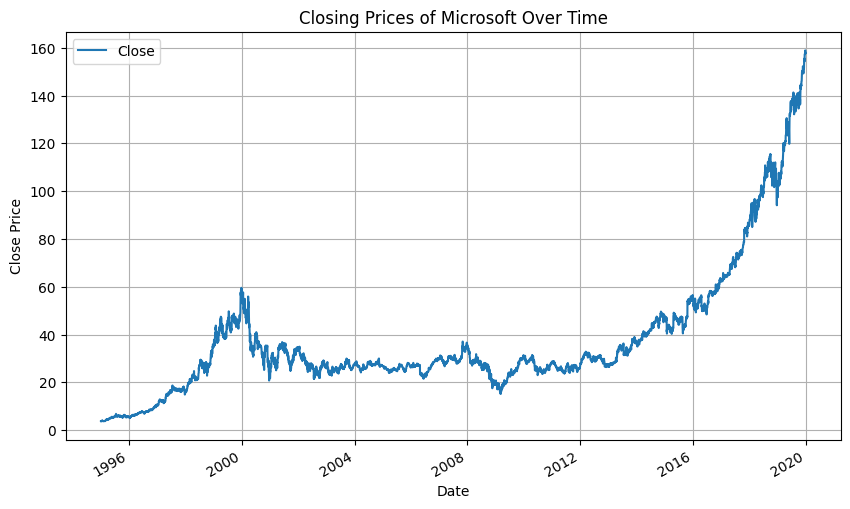

In [37]:
# Plot the closing prices over time
stock_df.plot(x='Date', y='Close', figsize=(10, 6))
plt.title('Closing Prices of Microsoft Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [38]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6294 entries, 1995-01-03 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6294 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB


rehearsal:

In [39]:
#timeline period
n_past = 5

data = []
# create all possible sequences of length
for i in range(len(df) - n_past):
    data.append(df[i: i + n_past])

In [40]:
# Print out the first few sequences
print(len(data))
for i in range(3):
    print(data[i])
    print()

6289
               Close
Date                
1995-01-03  3.761719
1995-01-04  3.789063
1995-01-05  3.726563
1995-01-06  3.789063
1995-01-09  3.765625

               Close
Date                
1995-01-04  3.789063
1995-01-05  3.726563
1995-01-06  3.789063
1995-01-09  3.765625
1995-01-10  3.812500

               Close
Date                
1995-01-05  3.726563
1995-01-06  3.789063
1995-01-09  3.765625
1995-01-10  3.812500
1995-01-11  3.835938



In [41]:
print(data[6280])

                 Close
Date                  
2019-12-11  151.699997
2019-12-12  153.240005
2019-12-13  154.529999
2019-12-16  155.529999
2019-12-17  154.690002


Data Preprocessing:

In [42]:
#use for time sequence later
n_past = 60
scaler = MinMaxScaler(feature_range=(-1,1))
df = scaler.fit_transform(df.values.reshape(-1,1))
data = []
# create all possible sequences of length look_back
for i in range(len(df) - n_past):
    data.append(df[i: i + n_past])


data = np.array(data)

test_set_size = int(np.round(0.3 * data.shape[0]))
train_set_size = data.shape[0] - test_set_size

x_train = data[:train_set_size, :-1, :]
y_train = data[:train_set_size, -1, :]

x_test = data[train_set_size:, :-1]
y_test = data[train_set_size:, -1, :]


In [43]:
X_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

In [44]:
X_train.size(),y_train.size()


(torch.Size([4364, 59, 1]), torch.Size([4364, 1]))

In [45]:
X_test.size(), y_test.size()

(torch.Size([1870, 59, 1]), torch.Size([1870, 1]))

Model Implementation:

In [46]:
#Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

#define a validate model to evalute later
def validate(model, test_loader, loss_function, device):
    model.eval()  # Set the model to evaluation mode
    Closs = 0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            Closs += loss.item()

    average_loss = Closs / (batch_index + 1)

    print('Val Loss: {0:.7f}'.format(average_loss))
    print()
    return average_loss


Training and Evaluation:

Epoch [1/60], Train Loss: 0.070966
Epoch [2/60], Train Loss: 0.006151
Epoch [3/60], Train Loss: 0.000954
Epoch [4/60], Train Loss: 0.000750
Epoch [5/60], Train Loss: 0.000581
Epoch [6/60], Train Loss: 0.000573
Epoch [7/60], Train Loss: 0.000470
Epoch [8/60], Train Loss: 0.000456
Epoch [9/60], Train Loss: 0.000415
Val Loss: 0.0939437

Epoch [10/60], Train Loss: 0.000395, Val Loss: 0.093944
Epoch [11/60], Train Loss: 0.000381
Epoch [12/60], Train Loss: 0.000343
Epoch [13/60], Train Loss: 0.000354
Epoch [14/60], Train Loss: 0.000346
Epoch [15/60], Train Loss: 0.000312
Epoch [16/60], Train Loss: 0.000291
Epoch [17/60], Train Loss: 0.000374
Epoch [18/60], Train Loss: 0.000288
Epoch [19/60], Train Loss: 0.000259
Val Loss: 0.0371491

Epoch [20/60], Train Loss: 0.000278, Val Loss: 0.037149
Epoch [21/60], Train Loss: 0.000255
Epoch [22/60], Train Loss: 0.000280
Epoch [23/60], Train Loss: 0.000219
Epoch [24/60], Train Loss: 0.000216
Epoch [25/60], Train Loss: 0.000224
Epoch [26/60], Train Loss: 

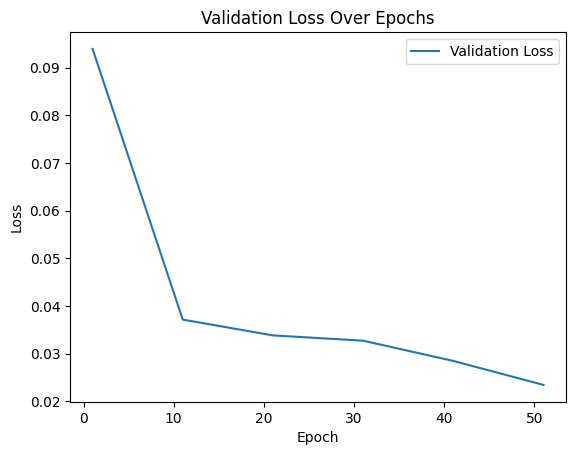

In [47]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#set parmaters
num_epochs= 60
input_size = 1
num_layers = 3
hidden_size= 72
output_size = 1
batch_size = 64

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

#load data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training the model
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch loss

    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Calculate average epoch loss
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)  # Store epoch training loss

    if (epoch+1) % 10 == 0:
        # Calculate validation loss every 10 epochs
        val_loss = validate(model, test_loader, loss_function, device)
        val_losses.append(val_loss)  # Store validation loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')
    else:
        # Print training loss for non-10th epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}')

# Plot validation loss
plt.plot(range(1, num_epochs+1, 10), val_losses, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


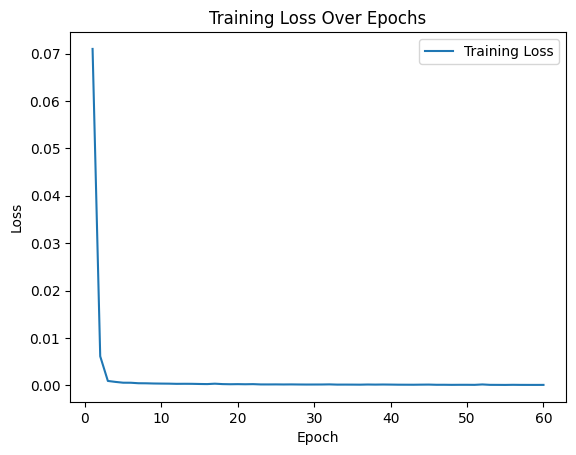

In [48]:
# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for test_batch_x, test_batch_y in test_loader:
        test_outputs = model(test_batch_x)
        test_loss += criterion(test_outputs, test_batch_y).item()

# Calculate average test loss
test_loss /= len(test_loader)

# Print test loss
print(f'Test Loss: {test_loss:.6f}')

Test Loss: 0.023444


R-squared: 0.9156


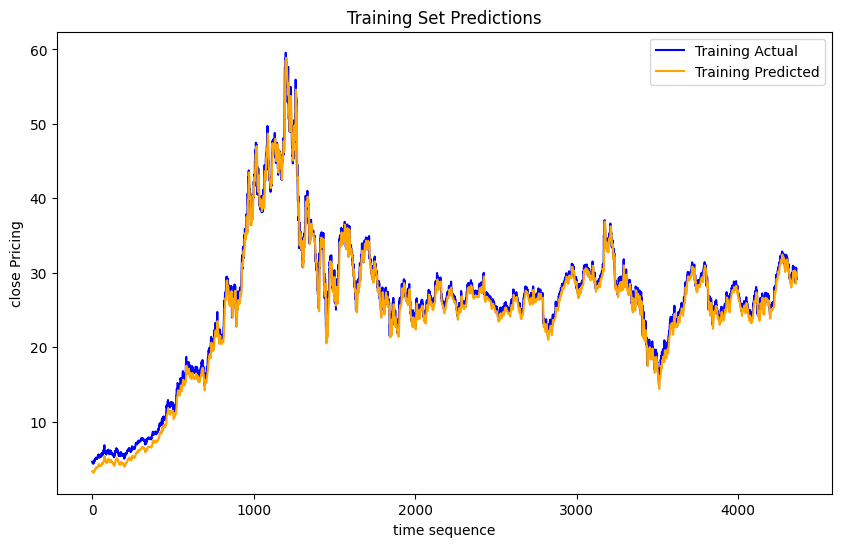

In [50]:
from sklearn.metrics import r2_score
def prediction(X, y):
    with torch.no_grad():
      predict = predict = model(X).numpy()
    predictions = predict.flatten()
    dy = np.zeros((X.shape[0], X.shape[1] + 1))
    dy[:, 0] = predictions
    dy = scaler.inverse_transform(dy)
    predictions = dc(dy[:, 0])
    dy1 = np.zeros((X.shape[0], X.shape[1] + 1))
    dy1[:, 0] = y.flatten()
    dy1 = scaler.inverse_transform(dy1)
    new_y = dc(dy1[:, 0])
    return predictions, new_y

# Get predictions and actual values for training and test sets
pred_train, new_y_train = prediction(X_train, y_train)
pred_test, new_y_test = prediction(X_test, y_test)

# Calculate R-squared value for test set
r2 = r2_score(new_y_test, pred_test)
print(f'R-squared: {r2:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(new_y_train, label='Training Actual', color='blue')
plt.plot(pred_train, label='Training Predicted', color='orange')
plt.title('Training Set Predictions')
plt.xlabel('time sequence')
plt.ylabel('close Pricing')
plt.legend()
plt.show()


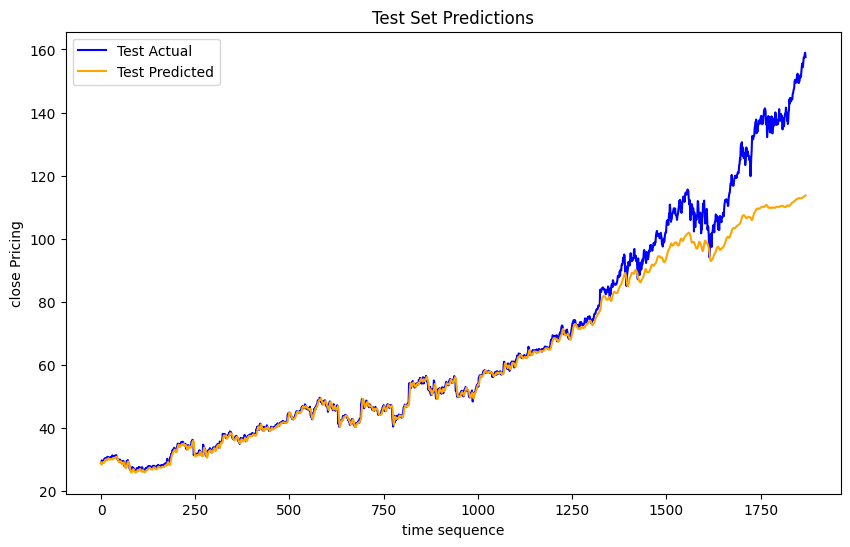

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(new_y_test, label='Test Actual', color='blue')
plt.plot(pred_test, label='Test Predicted', color='orange')
plt.title('Test Set Predictions')
plt.xlabel('time sequence')
plt.ylabel('close Pricing')
plt.legend()

plt.show()